In [1]:
import math
import datetime
import sys
import np as numpy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def loadDataSet(file_name, label_existed_flag):
    feats = []
    labels = []
    fr = open(file_name)
    lines = fr.readlines()
    for line in lines:
        temp = []
        allInfo = line.strip().split(',')
        dims = len(allInfo)
        if label_existed_flag == 1:
            for index in range(dims-1):
                temp.append(float(allInfo[index]))
            feats.append(temp)
            labels.append(float(allInfo[dims-1]))
        else:
            for index in range(dims):
                temp.append(float(allInfo[index]))
            feats.append(temp)
    fr.close()
    feats = np.array(feats)
    labels = np.array(labels)
    return feats, labels

In [4]:
train_file =  "../data/train_data.txt"
test_file = "../data/test_data.txt"
predict_file = "../projects/student/result.txt"

In [5]:
%%time
X_train, y_train = loadDataSet(train_file, 1)

CPU times: user 3.09 s, sys: 179 ms, total: 3.27 s
Wall time: 3.27 s


In [6]:
%%time
X_test, _ = loadDataSet(test_file, 0)
answer_file = "../projects/student/answer.txt"
_, y_test = loadDataSet(answer_file, 1)

CPU times: user 782 ms, sys: 28 ms, total: 810 ms
Wall time: 809 ms


In [7]:
def logistic_func(theta, x):
    return float(1) / (1 + math.e**(-x.dot(theta)))

In [8]:
def log_gradient(theta, x, y):
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = first_calc.T.dot(x)
    return final_calc

In [9]:
def cost_func(theta, x, y):
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)
    #return np.power(label - preval, 2).sum()

In [10]:
def grad_desc(theta_values, X, y, lr=.001, converge_change=.001):
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1
    return theta_values, np.array(cost_iter)

In [11]:
def pred_values(theta, X, hard=True):
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0)
    if hard:
        return pred_value
    return pred_prob

In [12]:
shape = X_train.shape[1]
shape

1000

In [13]:
y_flip = np.logical_not(y_train) #flip Setosa to be 1 and Versicolor to zero to be consistent

In [16]:
y_train

array([0., 0., 0., ..., 0., 1., 1.])

In [17]:
y_flip

array([ True,  True,  True, ...,  True, False, False])

np.sum(y_flip == y_train)

In [19]:
betas = np.zeros(shape)
betas.shape

(1000,)

In [20]:
fitted_values, cost_iter = grad_desc(betas, X_train, y_flip)
#print(fitted_values)

In [21]:
cost_iter

array([[0.        , 0.69314718],
       [1.        , 0.53198428],
       [2.        , 0.48347423],
       [3.        , 0.48142636],
       [4.        , 0.48232484]])

predicted_y = pred_values(fitted_values, X_train)
predicted_y

np.sum(y_flip == predicted_y)/np.size(X_train, 0)

In [22]:
predicted_y = pred_values(fitted_values, X_test)
predicted_y

array([1, 0, 1, ..., 1, 0, 0])

In [23]:
np.sum(y_test == predicted_y)/np.size(y_test)

0.2165

Text(0.5, 0, 'Iteration')

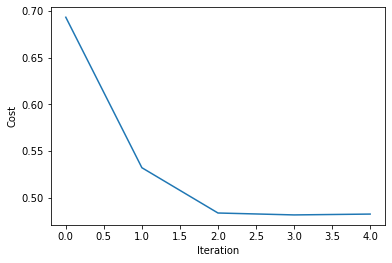

In [24]:
plt.plot(cost_iter[:,0], cost_iter[:,1])
plt.ylabel("Cost")
plt.xlabel("Iteration")
# sns.despine()

In [25]:
from scipy.optimize import fmin_l_bfgs_b

In [26]:
#normalize data
norm_X = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
norm_X.shape

(8000, 1000)

In [27]:
myargs = (norm_X, y_flip)
type(myargs)

tuple

In [28]:
betas = np.zeros(norm_X.shape[1])
betas.shape

(1000,)

In [29]:
lbfgs_fitted = fmin_l_bfgs_b(cost_func, x0=betas, args=myargs, fprime=log_gradient)
# lbfgs_fitted[0]

In [31]:
lbfgs_predicted = pred_values(lbfgs_fitted[0], norm_X, hard=True)
sum(lbfgs_predicted == y_flip)/np.size(X_train, 0)

0.631375

In [36]:
_epsilon = np.sqrt(np.finfo(float).eps)

In [55]:
def fmin_bfgs(f, x0, fprime=None, args=(), gtol=1e-5, norm=np.Inf,
              epsilon=_epsilon, maxiter=None, full_output=0, disp=1,
              retall=0, callback=None):
    """
    Minimize a function using the BFGS algorithm.
    Parameters
    ----------
    f : callable f(x,*args)
        Objective function to be minimized.
    x0 : ndarray
        Initial guess.
    fprime : callable f'(x,*args), optional
        Gradient of f.
    args : tuple, optional
        Extra arguments passed to f and fprime.
    gtol : float, optional
        Gradient norm must be less than gtol before successful termination.
    norm : float, optional
        Order of norm (Inf is max, -Inf is min)
    epsilon : int or ndarray, optional
        If fprime is approximated, use this value for the step size.
    callback : callable, optional
        An optional user-supplied function to call after each
        iteration.  Called as callback(xk), where xk is the
        current parameter vector.
    maxiter : int, optional
        Maximum number of iterations to perform.
    full_output : bool, optional
        If True,return fopt, func_calls, grad_calls, and warnflag
        in addition to xopt.
    disp : bool, optional
        Print convergence message if True.
    retall : bool, optional
        Return a list of results at each iteration if True.
    Returns
    -------
    xopt : ndarray
        Parameters which minimize f, i.e. f(xopt) == fopt.
    fopt : float
        Minimum value.
    gopt : ndarray
        Value of gradient at minimum, f'(xopt), which should be near 0.
    Bopt : ndarray
        Value of 1/f''(xopt), i.e. the inverse hessian matrix.
    func_calls : int
        Number of function_calls made.
    grad_calls : int
        Number of gradient calls made.
    warnflag : integer
        1 : Maximum number of iterations exceeded.
        2 : Gradient and/or function calls not changing.
        3 : NaN result encountered.
    allvecs  :  list
        The value of xopt at each iteration.  Only returned if retall is True.
    See also
    --------
    minimize: Interface to minimization algorithms for multivariate
        functions. See the 'BFGS' `method` in particular.
    Notes
    -----
    Optimize the function, f, whose gradient is given by fprime
    using the quasi-Newton method of Broyden, Fletcher, Goldfarb,
    and Shanno (BFGS)
    References
    ----------
    Wright, and Nocedal 'Numerical Optimization', 1999, pg. 198.
    """
    opts = {'gtol': gtol,
            'norm': norm,
            'eps': epsilon,
            'disp': disp,
            'maxiter': maxiter,
            'return_all': retall}

    res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)

    if full_output:
        retlist = (res['x'], res['fun'], res['jac'], res['hess_inv'],
                   res['nfev'], res['njev'], res['status'])
        if retall:
            retlist += (res['allvecs'], )
        return retlist
    else:
        if retall:
            return res['x'], res['allvecs']
        else:
            return res['x']

In [56]:
def _minimize_bfgs(fun, x0, args=(), jac=None, callback=None,
                   gtol=1e-5, norm=np.Inf, eps=_epsilon, maxiter=None,
                   disp=False, return_all=False,
                   **unknown_options):
    """
    Minimization of scalar function of one or more variables using the
    BFGS algorithm.
    Options
    -------
    disp : bool
        Set to True to print convergence messages.
    maxiter : int
        Maximum number of iterations to perform.
    gtol : float
        Gradient norm must be less than `gtol` before successful
        termination.
    norm : float
        Order of norm (Inf is max, -Inf is min).
    eps : float or ndarray
        If `jac` is approximated, use this value for the step size.
    """
    _check_unknown_options(unknown_options)
    f = fun
    fprime = jac
    epsilon = eps
    retall = return_all

    x0 = np.asarray(x0).flatten()
    if x0.ndim == 0:
        x0.shape = (1,)
    if maxiter is None:
        maxiter = len(x0) * 200
    func_calls, f = wrap_function(f, args)

    old_fval = f(x0)

    if fprime is None:
        grad_calls, myfprime = wrap_function(approx_fprime, (f, epsilon))
    else:
        grad_calls, myfprime = wrap_function(fprime, args)
    gfk = myfprime(x0)
    k = 0
    N = len(x0)
    I = np.eye(N, dtype=int)
    Hk = I

    # Sets the initial step guess to dx ~ 1
    old_old_fval = old_fval + np.linalg.norm(gfk) / 2

    xk = x0
    if retall:
        allvecs = [x0]
    warnflag = 0
    gnorm = vecnorm(gfk, ord=norm)
    while (gnorm > gtol) and (k < maxiter):
        pk = -np.dot(Hk, gfk)
        try:
            alpha_k, fc, gc, old_fval, old_old_fval, gfkp1 = \
                     _line_search_wolfe12(f, myfprime, xk, pk, gfk,
                                          old_fval, old_old_fval, amin=1e-100, amax=1e100)
        except _LineSearchError:
            # Line search failed to find a better solution.
            warnflag = 2
            break

        xkp1 = xk + alpha_k * pk
        if retall:
            allvecs.append(xkp1)
        sk = xkp1 - xk
        xk = xkp1
        if gfkp1 is None:
            gfkp1 = myfprime(xkp1)

        yk = gfkp1 - gfk
        gfk = gfkp1
        if callback is not None:
            callback(xk)
        k += 1
        gnorm = vecnorm(gfk, ord=norm)
        if (gnorm <= gtol):
            break

        if not np.isfinite(old_fval):
            # We correctly found +-Inf as optimal value, or something went
            # wrong.
            warnflag = 2
            break

        try:  # this was handled in numeric, let it remaines for more safety
            rhok = 1.0 / (np.dot(yk, sk))
        except ZeroDivisionError:
            rhok = 1000.0
            if disp:
                print("Divide-by-zero encountered: rhok assumed large")
        if isinf(rhok):  # this is patch for np
            rhok = 1000.0
            if disp:
                print("Divide-by-zero encountered: rhok assumed large")
        A1 = I - sk[:, np.newaxis] * yk[np.newaxis, :] * rhok
        A2 = I - yk[:, np.newaxis] * sk[np.newaxis, :] * rhok
        Hk = np.dot(A1, np.dot(Hk, A2)) + (rhok * sk[:, np.newaxis] *
                                                 sk[np.newaxis, :])

    fval = old_fval

    if warnflag == 2:
        msg = _status_message['pr_loss']
    elif k >= maxiter:
        warnflag = 1
        msg = _status_message['maxiter']
    elif np.isnan(gnorm) or np.isnan(fval) or np.isnan(xk).any():
        warnflag = 3
        msg = _status_message['nan']
    else:
        msg = _status_message['success']

    if disp:
        print("%s%s" % ("Warning: " if warnflag != 0 else "", msg))
        print("         Current function value: %f" % fval)
        print("         Iterations: %d" % k)
        print("         Function evaluations: %d" % func_calls[0])
        print("         Gradient evaluations: %d" % grad_calls[0])

    result = OptimizeResult(fun=fval, jac=gfk, hess_inv=Hk, nfev=func_calls[0],
                            njev=grad_calls[0], status=warnflag,
                            success=(warnflag == 0), message=msg, x=xk,
                            nit=k)
    if retall:
        result['allvecs'] = allvecs
    return result

In [57]:
def _check_unknown_options(unknown_options):
    if unknown_options:
        msg = ", ".join(map(str, unknown_options.keys()))
        # Stack level 4: this is called from _minimize_*, which is
        # called from another function in SciPy. Level 4 is the first
        # level in user code.
        warnings.warn("Unknown solver options: %s" % msg, OptimizeWarning, 4)

In [58]:
def wrap_function(function, args):
    ncalls = [0]
    if function is None:
        return ncalls, None

    def function_wrapper(*wrapper_args):
        ncalls[0] += 1
        return function(*(wrapper_args + args))

    return ncalls, function_wrapper

In [59]:
def vecnorm(x, ord=2):
    if ord == np.Inf:
        return np.amax(np.abs(x))
    elif ord == -np.Inf:
        return np.amin(np.abs(x))
    else:
        return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)

In [61]:
class _LineSearchError(RuntimeError):
    pass

In [63]:
def _line_search_wolfe12(f, fprime, xk, pk, gfk, old_fval, old_old_fval,
                         **kwargs):
    """
    Same as line_search_wolfe1, but fall back to line_search_wolfe2 if
    suitable step length is not found, and raise an exception if a
    suitable step length is not found.
    Raises
    ------
    _LineSearchError
        If no suitable step size is found
    """

    extra_condition = kwargs.pop('extra_condition', None)

    ret = line_search_wolfe1(f, fprime, xk, pk, gfk,
                             old_fval, old_old_fval,
                             **kwargs)

    if ret[0] is not None and extra_condition is not None:
        xp1 = xk + ret[0] * pk
        if not extra_condition(ret[0], xp1, ret[3], ret[5]):
            # Reject step if extra_condition fails
            ret = (None,)

    if ret[0] is None:
        # line search failed: try different one.
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', LineSearchWarning)
            kwargs2 = {}
            for key in ('c1', 'c2', 'amax'):
                if key in kwargs:
                    kwargs2[key] = kwargs[key]
            ret = line_search_wolfe2(f, fprime, xk, pk, gfk,
                                     old_fval, old_old_fval,
                                     extra_condition=extra_condition,
                                     **kwargs2)

    if ret[0] is None:
        raise _LineSearchError()

    return ret

In [66]:
"""
Functions
---------
.. autosummary::
   :toctree: generated/

    line_search_armijo
    line_search_wolfe1
    line_search_wolfe2
    scalar_search_wolfe1
    scalar_search_wolfe2

"""
from __future__ import division, print_function, absolute_import

from warnings import warn

from scipy.optimize import minpack2
import numpy as np
from scipy._lib.six import xrange

__all__ = ['LineSearchWarning', 'line_search_wolfe1', 'line_search_wolfe2',
           'scalar_search_wolfe1', 'scalar_search_wolfe2',
           'line_search_armijo']

class LineSearchWarning(RuntimeWarning):
    pass


#------------------------------------------------------------------------------
# Minpack's Wolfe line and scalar searches
#------------------------------------------------------------------------------

def line_search_wolfe1(f, fprime, xk, pk, gfk=None,
                       old_fval=None, old_old_fval=None,
                       args=(), c1=1e-4, c2=0.9, amax=50, amin=1e-8,
                       xtol=1e-14):
    """
    As `scalar_search_wolfe1` but do a line search to direction `pk`

    Parameters
    ----------
    f : callable
        Function `f(x)`
    fprime : callable
        Gradient of `f`
    xk : array_like
        Current point
    pk : array_like
        Search direction

    gfk : array_like, optional
        Gradient of `f` at point `xk`
    old_fval : float, optional
        Value of `f` at point `xk`
    old_old_fval : float, optional
        Value of `f` at point preceding `xk`

    The rest of the parameters are the same as for `scalar_search_wolfe1`.

    Returns
    -------
    stp, f_count, g_count, fval, old_fval
        As in `line_search_wolfe1`
    gval : array
        Gradient of `f` at the final point

    """
    if gfk is None:
        gfk = fprime(xk)

    if isinstance(fprime, tuple):
        eps = fprime[1]
        fprime = fprime[0]
        newargs = (f, eps) + args
        gradient = False
    else:
        newargs = args
        gradient = True

    gval = [gfk]
    gc = [0]
    fc = [0]

    def phi(s):
        fc[0] += 1
        return f(xk + s*pk, *args)

    def derphi(s):
        gval[0] = fprime(xk + s*pk, *newargs)
        if gradient:
            gc[0] += 1
        else:
            fc[0] += len(xk) + 1
        return np.dot(gval[0], pk)

    derphi0 = np.dot(gfk, pk)

    stp, fval, old_fval = scalar_search_wolfe1(
            phi, derphi, old_fval, old_old_fval, derphi0,
            c1=c1, c2=c2, amax=amax, amin=amin, xtol=xtol)

    return stp, fc[0], gc[0], fval, old_fval, gval[0]


def scalar_search_wolfe1(phi, derphi, phi0=None, old_phi0=None, derphi0=None,
                         c1=1e-4, c2=0.9,
                         amax=50, amin=1e-8, xtol=1e-14):
    """
    Scalar function search for alpha that satisfies strong Wolfe conditions

    alpha > 0 is assumed to be a descent direction.

    Parameters
    ----------
    phi : callable phi(alpha)
        Function at point `alpha`
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    phi0 : float, optional
        Value of phi at 0
    old_phi0 : float, optional
        Value of phi at previous point
    derphi0 : float, optional
        Value derphi at 0
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax, amin : float, optional
        Maximum and minimum step size
    xtol : float, optional
        Relative tolerance for an acceptable step.

    Returns
    -------
    alpha : float
        Step size, or None if no suitable step was found
    phi : float
        Value of `phi` at the new point `alpha`
    phi0 : float
        Value of `phi` at `alpha=0`

    Notes
    -----
    Uses routine DCSRCH from MINPACK.

    """

    if phi0 is None:
        phi0 = phi(0.)
    if derphi0 is None:
        derphi0 = derphi(0.)

    if old_phi0 is not None and derphi0 != 0:
        alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
        if alpha1 < 0:
            alpha1 = 1.0
    else:
        alpha1 = 1.0

    phi1 = phi0
    derphi1 = derphi0
    isave = np.zeros((2,), np.intc)
    dsave = np.zeros((13,), float)
    task = b'START'

    maxiter = 100
    for i in xrange(maxiter):
        stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
                                                   c1, c2, xtol, task,
                                                   amin, amax, isave, dsave)
        if task[:2] == b'FG':
            alpha1 = stp
            phi1 = phi(stp)
            derphi1 = derphi(stp)
        else:
            break
    else:
        # maxiter reached, the line search did not converge
        stp = None

    if task[:5] == b'ERROR' or task[:4] == b'WARN':
        stp = None  # failed

    return stp, phi1, phi0


line_search = line_search_wolfe1


#------------------------------------------------------------------------------
# Pure-Python Wolfe line and scalar searches
#------------------------------------------------------------------------------

def line_search_wolfe2(f, myfprime, xk, pk, gfk=None, old_fval=None,
                       old_old_fval=None, args=(), c1=1e-4, c2=0.9, amax=None,
                       extra_condition=None, maxiter=10):
    """Find alpha that satisfies strong Wolfe conditions.

    Parameters
    ----------
    f : callable f(x,*args)
        Objective function.
    myfprime : callable f'(x,*args)
        Objective function gradient.
    xk : ndarray
        Starting point.
    pk : ndarray
        Search direction.
    gfk : ndarray, optional
        Gradient value for x=xk (xk being the current parameter
        estimate). Will be recomputed if omitted.
    old_fval : float, optional
        Function value for x=xk. Will be recomputed if omitted.
    old_old_fval : float, optional
        Function value for the point preceding x=xk
    args : tuple, optional
        Additional arguments passed to objective function.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    extra_condition : callable, optional
        A callable of the form ``extra_condition(alpha, x, f, g)``
        returning a boolean. Arguments are the proposed step ``alpha``
        and the corresponding ``x``, ``f`` and ``g`` values. The line search 
        accepts the value of ``alpha`` only if this 
        callable returns ``True``. If the callable returns ``False`` 
        for the step length, the algorithm will continue with 
        new iterates. The callable is only called for iterates 
        satisfying the strong Wolfe conditions.
    maxiter : int, optional
        Maximum number of iterations to perform

    Returns
    -------
    alpha : float or None
        Alpha for which ``x_new = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    fc : int
        Number of function evaluations made.
    gc : int
        Number of gradient evaluations made.
    new_fval : float or None
        New function value ``f(x_new)=f(x0+alpha*pk)``,
        or None if the line search algorithm did not converge.
    old_fval : float
        Old function value ``f(x0)``.
    new_slope : float or None
        The local slope along the search direction at the
        new value ``<myfprime(x_new), pk>``,
        or None if the line search algorithm did not converge.


    Notes
    -----
    Uses the line search algorithm to enforce strong Wolfe
    conditions.  See Wright and Nocedal, 'Numerical Optimization',
    1999, pg. 59-60.

    For the zoom phase it uses an algorithm by [...].

    """
    fc = [0]
    gc = [0]
    gval = [None]
    gval_alpha = [None]

    def phi(alpha):
        fc[0] += 1
        return f(xk + alpha * pk, *args)

    if isinstance(myfprime, tuple):
        def derphi(alpha):
            fc[0] += len(xk) + 1
            eps = myfprime[1]
            fprime = myfprime[0]
            newargs = (f, eps) + args
            gval[0] = fprime(xk + alpha * pk, *newargs)  # store for later use
            gval_alpha[0] = alpha
            return np.dot(gval[0], pk)
    else:
        fprime = myfprime

        def derphi(alpha):
            gc[0] += 1
            gval[0] = fprime(xk + alpha * pk, *args)  # store for later use
            gval_alpha[0] = alpha
            return np.dot(gval[0], pk)

    if gfk is None:
        gfk = fprime(xk, *args)
    derphi0 = np.dot(gfk, pk)

    if extra_condition is not None:
        # Add the current gradient as argument, to avoid needless
        # re-evaluation
        def extra_condition2(alpha, phi):
            if gval_alpha[0] != alpha:
                derphi(alpha)
            x = xk + alpha * pk
            return extra_condition(alpha, x, phi, gval[0])
    else:
        extra_condition2 = None

    alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
            phi, derphi, old_fval, old_old_fval, derphi0, c1, c2, amax,
            extra_condition2, maxiter=maxiter)

    if derphi_star is None:
        warn('The line search algorithm did not converge', LineSearchWarning)
    else:
        # derphi_star is a number (derphi) -- so use the most recently
        # calculated gradient used in computing it derphi = gfk*pk
        # this is the gradient at the next step no need to compute it
        # again in the outer loop.
        derphi_star = gval[0]

    return alpha_star, fc[0], gc[0], phi_star, old_fval, derphi_star


def scalar_search_wolfe2(phi, derphi, phi0=None,
                         old_phi0=None, derphi0=None,
                         c1=1e-4, c2=0.9, amax=None,
                         extra_condition=None, maxiter=10):
    """Find alpha that satisfies strong Wolfe conditions.

    alpha > 0 is assumed to be a descent direction.

    Parameters
    ----------
    phi : callable phi(alpha)
        Objective scalar function.
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    phi0 : float, optional
        Value of phi at 0
    old_phi0 : float, optional
        Value of phi at previous point
    derphi0 : float, optional
        Value of derphi at 0
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    extra_condition : callable, optional
        A callable of the form ``extra_condition(alpha, phi_value)``
        returning a boolean. The line search accepts the value
        of ``alpha`` only if this callable returns ``True``.
        If the callable returns ``False`` for the step length,
        the algorithm will continue with new iterates.
        The callable is only called for iterates satisfying
        the strong Wolfe conditions.
    maxiter : int, optional
        Maximum number of iterations to perform

    Returns
    -------
    alpha_star : float or None
        Best alpha, or None if the line search algorithm did not converge.
    phi_star : float
        phi at alpha_star
    phi0 : float
        phi at 0
    derphi_star : float or None
        derphi at alpha_star, or None if the line search algorithm
        did not converge.

    Notes
    -----
    Uses the line search algorithm to enforce strong Wolfe
    conditions.  See Wright and Nocedal, 'Numerical Optimization',
    1999, pg. 59-60.

    For the zoom phase it uses an algorithm by [...].

    """

    if phi0 is None:
        phi0 = phi(0.)

    if derphi0 is None:
        derphi0 = derphi(0.)

    alpha0 = 0
    if old_phi0 is not None and derphi0 != 0:
        alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
    else:
        alpha1 = 1.0

    if alpha1 < 0:
        alpha1 = 1.0

    if amax is not None:
        alpha1 = min(alpha1, amax)

    phi_a1 = phi(alpha1)
    #derphi_a1 = derphi(alpha1)  evaluated below

    phi_a0 = phi0
    derphi_a0 = derphi0

    if extra_condition is None:
        extra_condition = lambda alpha, phi: True

    for i in xrange(maxiter):
        if alpha1 == 0 or (amax is not None and alpha0 == amax):
            # alpha1 == 0: This shouldn't happen. Perhaps the increment has
            # slipped below machine precision?
            alpha_star = None
            phi_star = phi0
            phi0 = old_phi0
            derphi_star = None

            if alpha1 == 0:
                msg = 'Rounding errors prevent the line search from converging'
            else:
                msg = "The line search algorithm could not find a solution " + \
                      "less than or equal to amax: %s" % amax

            warn(msg, LineSearchWarning)
            break

        if (phi_a1 > phi0 + c1 * alpha1 * derphi0) or \
           ((phi_a1 >= phi_a0) and (i > 1)):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha0, alpha1, phi_a0,
                              phi_a1, derphi_a0, phi, derphi,
                              phi0, derphi0, c1, c2, extra_condition)
            break

        derphi_a1 = derphi(alpha1)
        if (abs(derphi_a1) <= -c2*derphi0):
            if extra_condition(alpha1, phi_a1):
                alpha_star = alpha1
                phi_star = phi_a1
                derphi_star = derphi_a1
                break

        if (derphi_a1 >= 0):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha1, alpha0, phi_a1,
                              phi_a0, derphi_a1, phi, derphi,
                              phi0, derphi0, c1, c2, extra_condition)
            break

        alpha2 = 2 * alpha1  # increase by factor of two on each iteration
        if amax is not None:
            alpha2 = min(alpha2, amax)
        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi(alpha1)
        derphi_a0 = derphi_a1

    else:
        # stopping test maxiter reached
        alpha_star = alpha1
        phi_star = phi_a1
        derphi_star = None
        warn('The line search algorithm did not converge', LineSearchWarning)

    return alpha_star, phi_star, phi0, derphi_star


def _cubicmin(a, fa, fpa, b, fb, c, fc):
    """
    Finds the minimizer for a cubic polynomial that goes through the
    points (a,fa), (b,fb), and (c,fc) with derivative at a of fpa.

    If no minimizer can be found return None

    """
    # f(x) = A *(x-a)^3 + B*(x-a)^2 + C*(x-a) + D

    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db,
                                            fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _quadmin(a, fa, fpa, b, fb):
    """
    Finds the minimizer for a quadratic polynomial that goes through
    the points (a,fa), (b,fb) with derivative at a of fpa,

    """
    # f(x) = B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fa
            C = fpa
            db = b - a * 1.0
            B = (fb - D - C * db) / (db * db)
            xmin = a - C / (2.0 * B)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo,
          phi, derphi, phi0, derphi0, c1, c2, extra_condition):
    """
    Part of the optimization algorithm in `scalar_search_wolfe2`.
    """

    maxiter = 10
    i = 0
    delta1 = 0.2  # cubic interpolant check
    delta2 = 0.1  # quadratic interpolant check
    phi_rec = phi0
    a_rec = 0
    while True:
        # interpolate to find a trial step length between a_lo and
        # a_hi Need to choose interpolation here.  Use cubic
        # interpolation and then if the result is within delta *
        # dalpha or outside of the interval bounded by a_lo or a_hi
        # then use quadratic interpolation, if the result is still too
        # close, then use bisection

        dalpha = a_hi - a_lo
        if dalpha < 0:
            a, b = a_hi, a_lo
        else:
            a, b = a_lo, a_hi

        # minimizer of cubic interpolant
        # (uses phi_lo, derphi_lo, phi_hi, and the most recent value of phi)
        #
        # if the result is too close to the end points (or out of the
        # interval) then use quadratic interpolation with phi_lo,
        # derphi_lo and phi_hi if the result is still too close to the
        # end points (or out of the interval) then use bisection

        if (i > 0):
            cchk = delta1 * dalpha
            a_j = _cubicmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi,
                            a_rec, phi_rec)
        if (i == 0) or (a_j is None) or (a_j > b - cchk) or (a_j < a + cchk):
            qchk = delta2 * dalpha
            a_j = _quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha

        # Check new value of a_j

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1*a_j*derphi0) or (phi_aj >= phi_lo):
            phi_rec = phi_hi
            a_rec = a_hi
            a_hi = a_j
            phi_hi = phi_aj
        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2*derphi0 and extra_condition(a_j, phi_aj):
                a_star = a_j
                val_star = phi_aj
                valprime_star = derphi_aj
                break
            if derphi_aj*(a_hi - a_lo) >= 0:
                phi_rec = phi_hi
                a_rec = a_hi
                a_hi = a_lo
                phi_hi = phi_lo
            else:
                phi_rec = phi_lo
                a_rec = a_lo
            a_lo = a_j
            phi_lo = phi_aj
            derphi_lo = derphi_aj
        i += 1
        if (i > maxiter):
            # Failed to find a conforming step size
            a_star = None
            val_star = None
            valprime_star = None
            break
    return a_star, val_star, valprime_star


#------------------------------------------------------------------------------
# Armijo line and scalar searches
#------------------------------------------------------------------------------

def line_search_armijo(f, xk, pk, gfk, old_fval, args=(), c1=1e-4, alpha0=1):
    """Minimize over alpha, the function ``f(xk+alpha pk)``.

    Parameters
    ----------
    f : callable
        Function to be minimized.
    xk : array_like
        Current point.
    pk : array_like
        Search direction.
    gfk : array_like
        Gradient of `f` at point `xk`.
    old_fval : float
        Value of `f` at point `xk`.
    args : tuple, optional
        Optional arguments.
    c1 : float, optional
        Value to control stopping criterion.
    alpha0 : scalar, optional
        Value of `alpha` at start of the optimization.

    Returns
    -------
    alpha
    f_count
    f_val_at_alpha

    Notes
    -----
    Uses the interpolation algorithm (Armijo backtracking) as suggested by
    Wright and Nocedal in 'Numerical Optimization', 1999, pg. 56-57

    """
    xk = np.atleast_1d(xk)
    fc = [0]

    def phi(alpha1):
        fc[0] += 1
        return f(xk + alpha1*pk, *args)

    if old_fval is None:
        phi0 = phi(0.)
    else:
        phi0 = old_fval  # compute f(xk) -- done in past loop

    derphi0 = np.dot(gfk, pk)
    alpha, phi1 = scalar_search_armijo(phi, phi0, derphi0, c1=c1,
                                       alpha0=alpha0)
    return alpha, fc[0], phi1


def line_search_BFGS(f, xk, pk, gfk, old_fval, args=(), c1=1e-4, alpha0=1):
    """
    Compatibility wrapper for `line_search_armijo`
    """
    r = line_search_armijo(f, xk, pk, gfk, old_fval, args=args, c1=c1,
                           alpha0=alpha0)
    return r[0], r[1], 0, r[2]


def scalar_search_armijo(phi, phi0, derphi0, c1=1e-4, alpha0=1, amin=0):
    """Minimize over alpha, the function ``phi(alpha)``.

    Uses the interpolation algorithm (Armijo backtracking) as suggested by
    Wright and Nocedal in 'Numerical Optimization', 1999, pg. 56-57

    alpha > 0 is assumed to be a descent direction.

    Returns
    -------
    alpha
    phi1

    """
    phi_a0 = phi(alpha0)
    if phi_a0 <= phi0 + c1*alpha0*derphi0:
        return alpha0, phi_a0

    # Otherwise compute the minimizer of a quadratic interpolant:

    alpha1 = -(derphi0) * alpha0**2 / 2.0 / (phi_a0 - phi0 - derphi0 * alpha0)
    phi_a1 = phi(alpha1)

    if (phi_a1 <= phi0 + c1*alpha1*derphi0):
        return alpha1, phi_a1

    # Otherwise loop with cubic interpolation until we find an alpha which
    # satisfies the first Wolfe condition (since we are backtracking, we will
    # assume that the value of alpha is not too small and satisfies the second
    # condition.

    while alpha1 > amin:       # we are assuming alpha>0 is a descent direction
        factor = alpha0**2 * alpha1**2 * (alpha1-alpha0)
        a = alpha0**2 * (phi_a1 - phi0 - derphi0*alpha1) - \
            alpha1**2 * (phi_a0 - phi0 - derphi0*alpha0)
        a = a / factor
        b = -alpha0**3 * (phi_a1 - phi0 - derphi0*alpha1) + \
            alpha1**3 * (phi_a0 - phi0 - derphi0*alpha0)
        b = b / factor

        alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)
        phi_a2 = phi(alpha2)

        if (phi_a2 <= phi0 + c1*alpha2*derphi0):
            return alpha2, phi_a2

        if (alpha1 - alpha2) > alpha1 / 2.0 or (1 - alpha2/alpha1) < 0.96:
            alpha2 = alpha1 / 2.0

        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi_a2

    # Failed to find a suitable step length
    return None, phi_a1


#------------------------------------------------------------------------------
# Non-monotone line search for DF-SANE
#------------------------------------------------------------------------------

def _nonmonotone_line_search_cruz(f, x_k, d, prev_fs, eta,
                                  gamma=1e-4, tau_min=0.1, tau_max=0.5):
    """
    Nonmonotone backtracking line search as described in [1]_

    Parameters
    ----------
    f : callable
        Function returning a tuple ``(f, F)`` where ``f`` is the value
        of a merit function and ``F`` the residual.
    x_k : ndarray
        Initial position
    d : ndarray
        Search direction
    prev_fs : float
        List of previous merit function values. Should have ``len(prev_fs) <= M``
        where ``M`` is the nonmonotonicity window parameter.
    eta : float
        Allowed merit function increase, see [1]_
    gamma, tau_min, tau_max : float, optional
        Search parameters, see [1]_

    Returns
    -------
    alpha : float
        Step length
    xp : ndarray
        Next position
    fp : float
        Merit function value at next position
    Fp : ndarray
        Residual at next position

    References
    ----------
    [1] "Spectral residual method without gradient information for solving
        large-scale nonlinear systems of equations." W. La Cruz,
        J.M. Martinez, M. Raydan. Math. Comp. **75**, 1429 (2006).

    """
    f_k = prev_fs[-1]
    f_bar = max(prev_fs)

    alpha_p = 1
    alpha_m = 1
    alpha = 1

    while True:
        xp = x_k + alpha_p * d
        fp, Fp = f(xp)

        if fp <= f_bar + eta - gamma * alpha_p**2 * f_k:
            alpha = alpha_p
            break

        alpha_tp = alpha_p**2 * f_k / (fp + (2*alpha_p - 1)*f_k)

        xp = x_k - alpha_m * d
        fp, Fp = f(xp)

        if fp <= f_bar + eta - gamma * alpha_m**2 * f_k:
            alpha = -alpha_m
            break

        alpha_tm = alpha_m**2 * f_k / (fp + (2*alpha_m - 1)*f_k)

        alpha_p = np.clip(alpha_tp, tau_min * alpha_p, tau_max * alpha_p)
        alpha_m = np.clip(alpha_tm, tau_min * alpha_m, tau_max * alpha_m)

    return alpha, xp, fp, Fp


def _nonmonotone_line_search_cheng(f, x_k, d, f_k, C, Q, eta,
                                   gamma=1e-4, tau_min=0.1, tau_max=0.5,
                                   nu=0.85):
    """
    Nonmonotone line search from [1]

    Parameters
    ----------
    f : callable
        Function returning a tuple ``(f, F)`` where ``f`` is the value
        of a merit function and ``F`` the residual.
    x_k : ndarray
        Initial position
    d : ndarray
        Search direction
    f_k : float
        Initial merit function value
    C, Q : float
        Control parameters. On the first iteration, give values
        Q=1.0, C=f_k
    eta : float
        Allowed merit function increase, see [1]_
    nu, gamma, tau_min, tau_max : float, optional
        Search parameters, see [1]_

    Returns
    -------
    alpha : float
        Step length
    xp : ndarray
        Next position
    fp : float
        Merit function value at next position
    Fp : ndarray
        Residual at next position
    C : float
        New value for the control parameter C
    Q : float
        New value for the control parameter Q

    References
    ----------
    .. [1] W. Cheng & D.-H. Li, ''A derivative-free nonmonotone line
           search and its application to the spectral residual
           method'', IMA J. Numer. Anal. 29, 814 (2009).

    """
    alpha_p = 1
    alpha_m = 1
    alpha = 1

    while True:
        xp = x_k + alpha_p * d
        fp, Fp = f(xp)

        if fp <= C + eta - gamma * alpha_p**2 * f_k:
            alpha = alpha_p
            break

        alpha_tp = alpha_p**2 * f_k / (fp + (2*alpha_p - 1)*f_k)

        xp = x_k - alpha_m * d
        fp, Fp = f(xp)

        if fp <= C + eta - gamma * alpha_m**2 * f_k:
            alpha = -alpha_m
            break

        alpha_tm = alpha_m**2 * f_k / (fp + (2*alpha_m - 1)*f_k)

        alpha_p = np.clip(alpha_tp, tau_min * alpha_p, tau_max * alpha_p)
        alpha_m = np.clip(alpha_tm, tau_min * alpha_m, tau_max * alpha_m)

    # Update C and Q
    Q_next = nu * Q + 1
    C = (nu * Q * (C + eta) + fp) / Q_next
    Q = Q_next

    return alpha, xp, fp, Fp, C, Q



In [73]:
# standard status messages of optimizers
_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.',
                   'nan': 'NaN result encountered.'}

In [68]:
from numpy import (atleast_1d, eye, mgrid, argmin, zeros, shape, squeeze,
                   asarray, sqrt, Inf, asfarray, isinf)

In [71]:
import warnings

lbfgs_fitted2 = fmin_bfgs(cost_func, x0=betas, fprime=log_gradient, args=myargs, gtol=1e-5, norm=np.Inf,
              epsilon=_epsilon, maxiter=None, full_output=0, disp=1,
              retall=0, callback=None)

In [76]:
lbfgs_fitted2 = fmin_bfgs(cost_func, x0=betas, fprime=log_gradient, args=myargs)
# , gtol=1e-5, norm=np.Inf,
#               epsilon=_epsilon, maxiter=None, full_output=0, disp=1,
#               retall=0, callback=None)

         Current function value: 0.470132
         Iterations: 342
         Function evaluations: 2382
         Gradient evaluations: 2370


In [75]:
class OptimizeResult(dict):
    """ Represents the optimization result.
    Attributes
    ----------
    x : ndarray
        The solution of the optimization.
    success : bool
        Whether or not the optimizer exited successfully.
    status : int
        Termination status of the optimizer. Its value depends on the
        underlying solver. Refer to `message` for details.
    message : str
        Description of the cause of the termination.
    fun, jac, hess: ndarray
        Values of objective function, its Jacobian and its Hessian (if
        available). The Hessians may be approximations, see the documentation
        of the function in question.
    hess_inv : object
        Inverse of the objective function's Hessian; may be an approximation.
        Not available for all solvers. The type of this attribute may be
        either np.ndarray or scipy.sparse.linalg.LinearOperator.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
    nit : int
        Number of iterations performed by the optimizer.
    maxcv : float
        The maximum constraint violation.
    Notes
    -----
    There may be additional attributes not listed above depending of the
    specific solver. Since this class is essentially a subclass of dict
    with attribute accessors, one can see which attributes are available
    using the `keys()` method.
    """
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in sorted(self.items())])
        else:
            return self.__class__.__name__ + "()"

    def __dir__(self):
        return list(self.keys())
